In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download and prepare
data = yf.download('RELIANCE.NS', start='2019-02-01', end='2024-02-01')
data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# RSI function
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# All features
data['Returns'] = data['Close'].pct_change()
data['MA_10'] = data['Close'].rolling(10).mean()
data['MA_20'] = data['Close'].rolling(20).mean()
data['MA_50'] = data['Close'].rolling(50).mean()
data['RSI'] = calculate_rsi(data['Close'])
data['Volatility'] = data['Returns'].rolling(30).std()
data['Momentum'] = data['Close'] - data['Close'].shift(10)

print("Data loaded with all features!")
print(data.shape)
print(data.columns.tolist())

[*********************100%***********************]  1 of 1 completed

Data loaded with all features!
(1233, 12)
['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA_10', 'MA_20', 'MA_50', 'RSI', 'Volatility', 'Momentum']


In [2]:
# Create target variable (tomorrow's price)
data['Target'] = data['Close'].shift(-1)

print("Target created!")
print(data[['Close', 'Target']].tail(10))


Target created!
                  Close       Target
Date                                
2024-01-16  1379.762711  1349.511705
2024-01-17  1349.511705  1341.471203
2024-01-18  1341.471203  1365.890429
2024-01-19  1365.890429  1361.671682
2024-01-23  1361.671682  1325.414993
2024-01-24  1325.414993  1333.083178
2024-01-25  1333.083178  1354.474932
2024-01-29  1354.474932  1449.223597
2024-01-30  1449.223597  1393.684661
2024-01-31  1393.684661          NaN


In [3]:
# Remove rows with NaN values
data_clean = data.dropna()

print(f"Original data: {len(data)} rows")
print(f"After removing NaN: {len(data_clean)} rows")
print(f"Rows removed: {len(data) - len(data_clean)}")

# Check what we have
print("\nColumns available:")
print(data_clean.columns.tolist())

Original data: 1233 rows
After removing NaN: 1183 rows
Rows removed: 50

Columns available:
['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA_10', 'MA_20', 'MA_50', 'RSI', 'Volatility', 'Momentum', 'Target']


In [4]:
# Select features
features = ['MA_10', 'MA_20', 'MA_50', 'RSI', 'Volatility', 'Momentum', 'Volume']
X = data_clean[features]
y = data_clean['Target']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nFirst 5 rows of X:")
print(X.head())


Features (X) shape: (1183, 7)
Target (y) shape: (1183,)

First 5 rows of X:
                 MA_10       MA_20       MA_50        RSI  Volatility  \
Date                                                                    
2019-04-18  600.801240  604.123031  578.916570  49.299811    0.016018   
2019-04-22  599.956336  604.123035  580.037173  52.462721    0.016016   
2019-04-23  599.380466  603.460450  580.935437  44.216547    0.016063   
2019-04-24  600.016369  603.411537  581.631812  42.493267    0.015966   
2019-04-25  602.693374  604.712244  582.457593  49.078572    0.016087   

             Momentum    Volume  
Date                             
2019-04-18  -7.893089  39286534  
2019-04-22  -8.449034  23607922  
2019-04-23  -5.758706  19807450  
2019-04-24   6.359032  16101112  
2019-04-25  26.770054  30469914  


In [5]:
from sklearn.model_selection import train_test_split

# Calculate 80% point
split_point = int(len(X) * 0.8)

# Split by time (no shuffling!)
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]

print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")
print(f"\nTrain period: {X_train.index[0]} to {X_train.index[-1]}")
print(f"Test period: {X_test.index[0]} to {X_test.index[-1]}")

Training set: 946 samples
Testing set: 237 samples

Train period: 2019-04-18 00:00:00 to 2023-02-09 00:00:00
Test period: 2023-02-10 00:00:00 to 2024-01-30 00:00:00


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Create and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

print("Linear Regression Model Trained!")
print(f"\nTraining Score (R²): {lr_model.score(X_train, y_train):.4f}")
print(f"Testing Score (R²): {lr_model.score(X_test, y_test):.4f}")

Linear Regression Model Trained!

Training Score (R²): 0.9915
Testing Score (R²): 0.9518


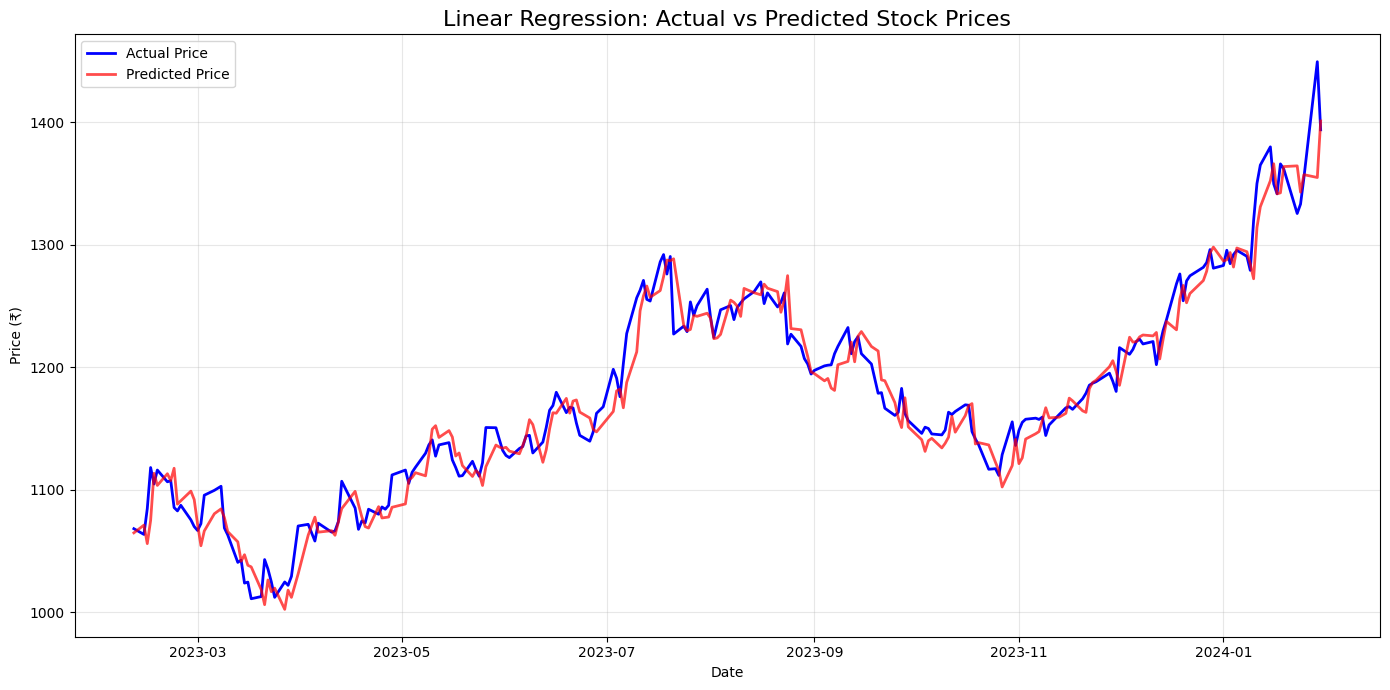

✓ Predictions visualized!


In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot actual test prices
plt.plot(y_test.index, y_test.values, label='Actual Price', linewidth=2, color='blue')

# Plot predicted prices
plt.plot(y_test.index, y_pred_test, label='Predicted Price', linewidth=2, color='red', alpha=0.7)

plt.title('Linear Regression: Actual vs Predicted Stock Prices', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/lr_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Predictions visualized!")


In [13]:
print("X_train (features) - first 5 rows:")
print(X_train.head())

print("\n" + "="*60)

print("\ny_train (targets) - first 5 values:")
print(y_train.head())

print("\n" + "="*60)

print("\nExample: April 18, 2019")
print("Input features:")
print(X_train.iloc[0])
print(f"\nTarget (tomorrow's price): {y_train.iloc[0]:.2f}")

Features scaled!

Before scaling (first sample):
MA_10         6.008012e+02
MA_20         6.041230e+02
MA_50         5.789166e+02
RSI           4.929981e+01
Volatility    1.601841e-02
Momentum     -7.893089e+00
Volume        3.928653e+07
Name: 2019-04-18 00:00:00, dtype: float64

After scaling (first sample):
[-1.38067425 -1.3567568  -1.43740423 -0.15145869 -0.45147133 -0.23857788
  0.95119549]


In [9]:
from sklearn.ensemble import RandomForestRegressor

# Create and train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred_test = rf_model.predict(X_test)

# Scores
rf_train_score = rf_model.score(X_train, y_train)
rf_test_score = rf_model.score(X_test, y_test)

print("Random Forest Model Trained!")
print(f"\nTraining Score (R²): {rf_train_score:.4f}")
print(f"Testing Score (R²): {rf_test_score:.4f}")

print("\n" + "="*50)
print("MODEL COMPARISON:")
print("="*50)
print(f"Linear Regression Test Score: 0.9518")
print(f"Random Forest Test Score:      {rf_test_score:.4f}")

Random Forest Model Trained!

Training Score (R²): 0.9989
Testing Score (R²): 0.6489

MODEL COMPARISON:
Linear Regression Test Score: 0.9518
Random Forest Test Score:      0.6489


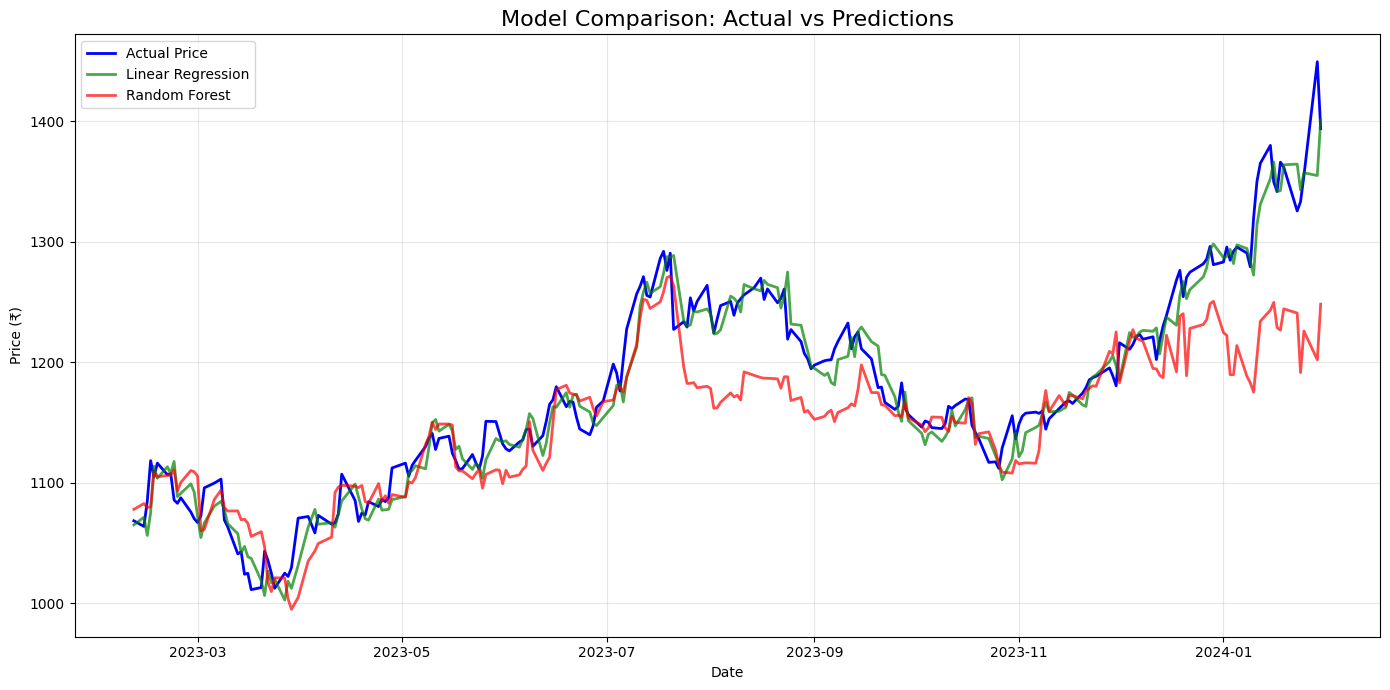

✓ Model comparison visualized!


In [10]:
plt.figure(figsize=(14, 7))

# Actual prices
plt.plot(y_test.index, y_test.values, label='Actual Price', linewidth=2, color='blue')

# Linear Regression predictions
plt.plot(y_test.index, y_pred_test, label='Linear Regression', linewidth=2, color='green', alpha=0.7)

# Random Forest predictions
plt.plot(y_test.index, rf_pred_test, label='Random Forest', linewidth=2, color='red', alpha=0.7)

plt.title('Model Comparison: Actual vs Predictions', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Model comparison visualized!")

In [15]:
from sklearn.preprocessing import StandardScaler

# Create scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled!")
print("\nBefore scaling (first sample):")
print(X_train.iloc[0])
print("\nAfter scaling (first sample):")
print(X_train_scaled[0])

Features scaled!

Before scaling (first sample):
MA_10         6.008012e+02
MA_20         6.041230e+02
MA_50         5.789166e+02
RSI           4.929981e+01
Volatility    1.601841e-02
Momentum     -7.893089e+00
Volume        3.928653e+07
Name: 2019-04-18 00:00:00, dtype: float64

After scaling (first sample):
[-1.38067425 -1.3567568  -1.43740423 -0.15145869 -0.45147133 -0.23857788
  0.95119549]


In [16]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\nX_train (first 3 rows):")
print(X_train.head(3))
print("\nX_test (first 3 rows):")
print(X_test.head(3))
print("\n" + "="*60)
print("y_train (first 5 values):")
print(y_train.head(5))
print("\ny_test (first 5 values):")
print(y_test.head(5))

X_train shape: (946, 7)
X_test shape: (237, 7)

X_train (first 3 rows):
                 MA_10       MA_20       MA_50        RSI  Volatility  \
Date                                                                    
2019-04-18  600.801240  604.123031  578.916570  49.299811    0.016018   
2019-04-22  599.956336  604.123035  580.037173  52.462721    0.016016   
2019-04-23  599.380466  603.460450  580.935437  44.216547    0.016063   

            Momentum    Volume  
Date                            
2019-04-18 -7.893089  39286534  
2019-04-22 -8.449034  23607922  
2019-04-23 -5.758706  19807450  

X_test (first 3 rows):
                  MA_10        MA_20        MA_50        RSI  Volatility  \
Date                                                                       
2023-02-10  1068.612951  1093.431523  1146.410012  33.704172    0.012863   
2023-02-13  1069.000960  1090.733630  1142.851164  34.770360    0.012756   
2023-02-14  1066.624914  1087.475395  1139.363075  34.649156    0.012

In [17]:
# Create comparison dataframe
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_test,
    'Difference': y_test.values - y_pred_test,
    'Error %': ((y_test.values - y_pred_test) / y_test.values * 100)
}, index=y_test.index)

print("PREDICTIONS VS ACTUAL (First 10 days):")
print("="*70)
print(comparison.head(10))

print("\n" + "="*70)
print("SUMMARY STATISTICS:")
print("="*70)
print(f"Average error: ₹{abs(comparison['Difference']).mean():.2f}")
print(f"Average error %: {abs(comparison['Error %']).mean():.2f}%")
print(f"Max error: ₹{abs(comparison['Difference']).max():.2f}")
print(f"Min error: ₹{abs(comparison['Difference']).min():.2f}")

PREDICTIONS VS ACTUAL (First 10 days):
                 Actual    Predicted  Difference   Error %
Date                                                      
2023-02-10  1068.293381  1064.903298    3.390083  0.317336
2023-02-13  1063.614438  1071.199270   -7.584832 -0.713119
2023-02-14  1084.635888  1056.109991   28.525897  2.629998
2023-02-15  1118.165632  1075.109546   43.056086  3.850600
2023-02-16  1104.721792  1113.460486   -8.738694 -0.791031
2023-02-17  1116.134257  1103.590303   12.543954  1.123875
2023-02-20  1106.547847  1113.130153   -6.582306 -0.594851
2023-02-21  1107.437937  1107.503024   -0.065087 -0.005877
2023-02-22  1085.548905  1117.589195  -32.040289 -2.951529
2023-02-23  1082.810002  1088.333667   -5.523665 -0.510123

SUMMARY STATISTICS:
Average error: ₹13.49
Average error %: 1.14%
Max error: ₹94.45
Min error: ₹0.02


In [18]:
from sklearn.preprocessing import StandardScaler

# Create scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled!")
print("\nBefore scaling (first sample):")
print(X_train.iloc[0].values)
print("\nAfter scaling (first sample):")
print(X_train_scaled[0])

Features scaled!

Before scaling (first sample):
[ 6.00801240e+02  6.04123031e+02  5.78916570e+02  4.92998107e+01
  1.60184141e-02 -7.89308906e+00  3.92865340e+07]

After scaling (first sample):
[-1.38067425 -1.3567568  -1.43740423 -0.15145869 -0.45147133 -0.23857788
  0.95119549]


In [19]:
# Train Linear Regression with scaled features
lr_model_scaled = LinearRegression()
lr_model_scaled.fit(X_train_scaled, y_train)

# Predictions
y_pred_scaled = lr_model_scaled.predict(X_test_scaled)

# Compare scores
print("="*60)
print("MODEL COMPARISON:")
print("="*60)
print(f"WITHOUT scaling - Test Score: {lr_model.score(X_test, y_test):.4f}")
print(f"WITH scaling    - Test Score: {lr_model_scaled.score(X_test_scaled, y_test):.4f}")
print("="*60)

MODEL COMPARISON:
WITHOUT scaling - Test Score: 0.9518
WITH scaling    - Test Score: 0.9518


In [20]:
# Get the most recent day's features
latest_features = data_clean[features].iloc[-1]

print("Latest available data (most recent day):")
print(f"Date: {data_clean.index[-1]}")
print("\nFeatures for that day:")
print(latest_features)


Latest available data (most recent day):
Date: 2024-01-30 00:00:00

Features for that day:
MA_10         1.362540e+03
MA_20         1.329776e+03
MA_50         1.263864e+03
RSI           7.234962e+01
Volatility    1.783892e-02
Momentum      9.931484e+01
Volume        1.409398e+07
Name: 2024-01-30 00:00:00, dtype: float64


In [21]:
# Reshape to 2D array (model expects this format)
latest_features_array = latest_features.values.reshape(1, -1)

# Scale it (using the SAME scaler we fit on training data)
latest_features_scaled = scaler.transform(latest_features_array)

# Predict next day's price
predicted_price = lr_model_scaled.predict(latest_features_scaled)[0]

print("="*60)
print("FUTURE PREDICTION")
print("="*60)
print(f"Based on data from: {data_clean.index[-1].date()}")
print(f"Predicted price for NEXT day: ₹{predicted_price:.2f}")
print("="*60)

FUTURE PREDICTION
Based on data from: 2024-01-30
Predicted price for NEXT day: ₹1400.88


C:\Users\sujan\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [22]:
# Check if we have Jan 31 actual price
jan31_actual = data_clean[data_clean.index == '2024-01-31']['Close'].values

if len(jan31_actual) > 0:
    actual_price = jan31_actual[0]
    error = abs(predicted_price - actual_price)
    error_pct = (error / actual_price) * 100
    
    print("="*60)
    print("PREDICTION ACCURACY CHECK")
    print("="*60)
    print(f"Predicted: ₹{predicted_price:.2f}")
    print(f"Actual:    ₹{actual_price:.2f}")
    print(f"Error:     ₹{error:.2f} ({error_pct:.2f}%)")
    print("="*60)
else:
    print("Jan 31 data not available in dataset")

Jan 31 data not available in dataset


In [23]:
# Download ONE more day to check
verification_data = yf.download('RELIANCE.NS', start='2024-01-31', end='2024-02-01')
if not verification_data.empty:
    actual_jan31 = verification_data['Close'].iloc[0]
    error = abs(predicted_price - actual_jan31)
    error_pct = (error / actual_jan31) * 100
    
    print(f"Predicted: ₹{predicted_price:.2f}")
    print(f"Actual:    ₹{actual_jan31:.2f}")
    print(f"Error:     ₹{error:.2f} ({error_pct:.2f}%)")
    

[*********************100%***********************]  1 of 1 completed


Predicted: ₹1400.88


TypeError: unsupported format string passed to Series.__format__

In [24]:
# Download and verify
verification_data = yf.download('RELIANCE.NS', start='2024-01-31', end='2024-02-01')

if not verification_data.empty:
    # Flatten columns if needed
    if isinstance(verification_data.columns, pd.MultiIndex):
        verification_data.columns = verification_data.columns.get_level_values(0)
    
    actual_jan31 = verification_data['Close'].iloc[0]
    error = abs(predicted_price - actual_jan31)
    error_pct = (error / actual_jan31) * 100
    
    print("="*60)
    print("PREDICTION VERIFICATION")
    print("="*60)
    print(f"Predicted: ₹{predicted_price:.2f}")
    print(f"Actual:    ₹{actual_jan31:.2f}")
    print(f"Error:     ₹{error:.2f} ({error_pct:.2f}%)")
    print("="*60)
    
    if error_pct < 2:
        print("✓ Excellent prediction! (<2% error)")
    elif error_pct < 5:
        print("✓ Good prediction! (<5% error)")
    else:
        print("⚠ Prediction was off by more than 5%")

[*********************100%***********************]  1 of 1 completed

PREDICTION VERIFICATION
Predicted: ₹1400.88
Actual:    ₹1416.14
Error:     ₹15.27 (1.08%)
✓ Excellent prediction! (<2% error)


In [26]:
import pickle

# Save the trained model and scaler
with open('../models/stock_predictor.pkl', 'wb') as f:
    pickle.dump(lr_model_scaled, f)

with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✓ Model saved successfully!")
print("\nYou can now:")
print("1. Load this model anytime")
print("2. Make new predictions without retraining")
print("3. Deploy it to predict daily")

✓ Model saved successfully!

You can now:
1. Load this model anytime
2. Make new predictions without retraining
3. Deploy it to predict daily
